# Question 3 — MAP Bayesian Image Denoising (Microscopy RGB)
This notebook implements MAP denoising with an i.i.d. Gaussian likelihood and a 4-neighbor MRF prior with pairwise cliques for three penalties: (A) squared L2, (B) L2, (C) Huber-regularized L1. Optimization uses gradient ascent with backtracking line search to ensure monotonic increase of the log posterior at each iteration.

Keys: ['microscopyImageNoisyScale350sigma0point06', 'microscopyImageOrig']
Noisy shape: (3, 528, 393)
Clean shape: (3, 528, 393)
Adjusted Noisy shape: (528, 393, 3)
Adjusted Clean shape: (528, 393, 3)
Estimated sigma: 0.1477242414077443


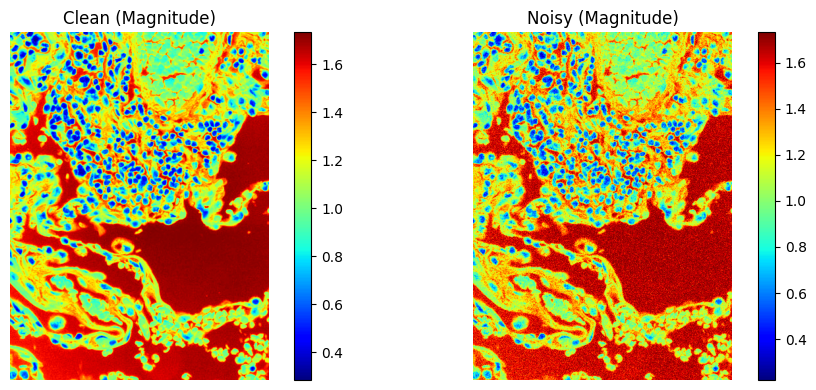

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

with h5py.File('data/assignmentImageDenoising_microscopy.mat', 'r') as f:
    keys = list(f.keys())
    print('Keys:', keys)
    data = {k: np.array(f[k]) for k in keys}

key_noisy = 'microscopyImageNoisyScale350sigma0point06'
key_clean = 'microscopyImageOrig'
image_noisy = data[key_noisy]
image_clean = data[key_clean]

print('Noisy shape:', image_noisy.shape)
print('Clean shape:', image_clean.shape)


def ensure_hw_c(img):
    if img.ndim == 2:
        return img[..., None]
    if img.shape[0] in (3,4) and img.ndim == 3:
        return np.moveaxis(img, 0, -1)
    return img

image_noisy = ensure_hw_c(image_noisy)
image_clean = ensure_hw_c(image_clean)
print('Adjusted Noisy shape:', image_noisy.shape)
print('Adjusted Clean shape:', image_clean.shape)

# Normalize to [0,1] for stability
def normalize01(img):
    img = img.astype(np.float64)
    m, M = img.min(), img.max()
    if M > m:
        return (img - m) / (M - m)
    return img

image_noisy = normalize01(image_noisy)
image_clean = normalize01(image_clean)


sigma_est = float(np.std(image_noisy - image_clean))
print('Estimated sigma:', sigma_est)


def magnitude(img):
    if img.ndim == 3:
        return np.linalg.norm(img, axis=-1)
    return np.abs(img)

def show_mag(img, title):
    mag = magnitude(img)
    plt.imshow(mag, cmap='jet')
    plt.title(title)
    plt.axis('off')
    plt.colorbar()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); show_mag(image_clean, 'Clean (Magnitude)')
plt.subplot(1,2,2); show_mag(image_noisy, 'Noisy (Magnitude)')
plt.tight_layout(); plt.show()

In [ ]:

def circshift_2d(img, dy, dx):
    return np.roll(np.roll(img, dy, axis=0), dx, axis=1)

def compute_rrmse(A, B):
    num = np.sum((A - B)**2)
    den = np.sum(A**2) + 1e-12
    return float(np.sqrt(num / den))

print('Utils ready.')

Utils ready.


In [ ]:

def prior_A(u):  # squared L2
    return np.sum(u**2, axis=-1)
def grad_A(u):
    return 2.0 * u

def prior_B(u, eps=1e-8):  # L2
    return np.sqrt(np.sum(u**2, axis=-1) + eps)
def grad_B(u, eps=1e-8):
    norm = np.sqrt(np.sum(u**2, axis=-1, keepdims=True) + eps)
    return u / norm

def prior_C(u, gamma):  # Huber on ||u||
    norm = np.sqrt(np.sum(u**2, axis=-1))
    return np.where(norm <= gamma, 0.5 * norm**2, gamma * norm - 0.5 * gamma**2)
def grad_C(u, gamma, eps=1e-8):
    norm = np.sqrt(np.sum(u**2, axis=-1, keepdims=True) + eps)
    return np.where(norm <= gamma, u, gamma * u / norm)

print('Priors ready.')

Priors ready.


In [ ]:
# 4-neighbor differences (wrap-around) and aggregated prior terms
def neighbor_diffs_4(x):
    # right, left, down, up
    right = circshift_2d(x, 0, +1)
    left  = circshift_2d(x, 0, -1)
    down  = circshift_2d(x, +1, 0)
    up    = circshift_2d(x, -1, 0)
    return [x - right, x - left, x - down, x - up]

def prior_penalty(x, prior_type, gamma=None):
    diffs = neighbor_diffs_4(x)
    total = 0.0
    if prior_type == 'A':
        for d in diffs: total += np.sum(prior_A(d))
    elif prior_type == 'B':
        for d in diffs: total += np.sum(prior_B(d))
    elif prior_type == 'C':
        assert gamma is not None, 'gamma required for Huber prior C'
        for d in diffs: total += np.sum(prior_C(d, gamma))
    else:
        raise ValueError('prior_type must be A, B, or C')
    return float(total)

def prior_gradient(x, prior_type, gamma=None):
    diffs = neighbor_diffs_4(x)
    grad = np.zeros_like(x)
    if prior_type == 'A':
        grads = [grad_A(d) for d in diffs]
    elif prior_type == 'B':
        grads = [grad_B(d) for d in diffs]
    elif prior_type == 'C':
        assert gamma is not None
        grads = [grad_C(d, gamma) for d in diffs]
    else:
        raise ValueError('prior_type must be A, B, or C')
    
    for g in grads: grad += g
    return grad

print('Neighborhood ops ready.')

Neighborhood ops ready.


In [18]:
# Log-posterior and gradient (Gaussian likelihood) with alpha in [0,1]
def log_posterior(x, y, alpha, prior_type, sigma, gamma=None):
    like = -0.5 / (sigma**2) * np.sum((x - y)**2)
    prior = - prior_penalty(x, prior_type, gamma)
    return (1 - alpha) * like + alpha * prior

def logpost_grad(x, y, alpha, prior_type, sigma, gamma=None):
    like_grad = (1 - alpha) * (1.0 / (sigma**2)) * (y - x)
    prior_grad = alpha * (- prior_gradient(x, prior_type, gamma))
    return like_grad + prior_grad

# Backtracking line search for monotonic increase
def gradient_ascent_map(y, alpha, prior_type, sigma, gamma=None, max_iter=150, tol=1e-7, s_init=0.1, beta=0.5):
    x = y.copy()
    obj = []
    s = s_init
    for it in range(max_iter):
        current = log_posterior(x, y, alpha, prior_type, sigma, gamma)
        g = logpost_grad(x, y, alpha, prior_type, sigma, gamma)
        # Try step sizes until improvement
        s_try = s
        improved = False
        while s_try > 1e-6:
            x_new = x + s_try * g
            new_val = log_posterior(x_new, y, alpha, prior_type, sigma, gamma)
            if new_val >= current:
                x, s, current = x_new, s_try * 1.05, new_val
                improved = True
                break
            s_try *= beta
        obj.append(current)
        if not improved:
            print(f'Iteration {it+1}: no improving step found, stopping.')
            break
        if it > 0 and abs(obj[-1] - obj[-2]) < tol:
            print(f'Converged at iteration {it+1}.')
            break
        if (it+1) % 10 == 0:
            print(f'Iter {it+1}: obj={current:.6f}, step={s:.6f}')
    return x, obj

print('Objective and optimizer ready.')

Objective and optimizer ready.


In [19]:
# Simple parameter grids for tuning (alpha in [0.1..0.9], gamma for C) using RRMSE
alpha_grid = [0.1, 0.3, 0.5, 0.7, 0.9]
gamma_grid = [0.05, 0.1, 0.2]

def tune_alpha(prior_type, sigma):
    best = (None, np.inf)
    for a in alpha_grid:
        x_hat, _ = gradient_ascent_map(image_noisy, a, prior_type, sigma, gamma=None if prior_type!='C' else 0.1, max_iter=60)
        r = compute_rrmse(image_clean, x_hat)
        if r < best[1]: best = (a, r)
    return best

def tune_alpha_gamma_C(sigma):
    best = (None, None, np.inf)
    for a in alpha_grid:
        for g in gamma_grid:
            x_hat, _ = gradient_ascent_map(image_noisy, a, 'C', sigma, gamma=g, max_iter=60)
            r = compute_rrmse(image_clean, x_hat)
            if r < best[2]: best = (a, g, r)
    return best

print('Tuning setup ready.')

Tuning setup ready.


In [20]:
# Optuna-based parameter tuning for A, B (alpha) and C (alpha, gamma)
import optuna
from optuna.samplers import TPESampler

# Tuning functions return (best_params_dict, best_rrmse)
def optuna_tune_A_or_B(prior_type, sigma, n_trials=30, seed=42):
    assert prior_type in ('A', 'B')
    def objective(trial):
        a = trial.suggest_float('alpha', 0.05, 0.95)
        x_hat, _ = gradient_ascent_map(image_noisy, a, prior_type, sigma, max_iter=80)
        return compute_rrmse(image_clean, x_hat)
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=seed))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    best_a = study.best_params['alpha']
    return ({'alpha': best_a}, study.best_value)

def optuna_tune_C(sigma, n_trials=40, seed=42):
    def objective(trial):
        a = trial.suggest_float('alpha', 0.05, 0.95)
        g = trial.suggest_float('gamma', 0.05, 0.5)
        x_hat, _ = gradient_ascent_map(image_noisy, a, 'C', sigma, gamma=g, max_iter=80)
        return compute_rrmse(image_clean, x_hat)
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=seed))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    best_a = study.best_params['alpha']
    best_g = study.best_params['gamma']
    return ({'alpha': best_a, 'gamma': best_g}, study.best_value)

print('Optuna tuning utilities ready.')

Optuna tuning utilities ready.


/Users/shivam/Documents/IITB_Courses/Sem6/CS736/assignmentImageDenoising/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# Run tuning (grid)
best_A_alpha, best_A_rrmse = tune_alpha('A', sigma_est)
best_B_alpha, best_B_rrmse = tune_alpha('B', sigma_est)
best_C_alpha, best_C_gamma, best_C_rrmse = tune_alpha_gamma_C(sigma_est)

print('Grid Best A alpha:', best_A_alpha, 'RRMSE:', best_A_rrmse)
print('Grid Best B alpha:', best_B_alpha, 'RRMSE:', best_B_rrmse)
print('Grid Best C alpha,gamma:', best_C_alpha, best_C_gamma, 'RRMSE:', best_C_rrmse)

# Run tuning (Optuna)
opt_A, opt_A_rrmse = optuna_tune_A_or_B('A', sigma_est, n_trials=30, seed=123)
opt_B, opt_B_rrmse = optuna_tune_A_or_B('B', sigma_est, n_trials=30, seed=123)
opt_C, opt_C_rrmse = optuna_tune_C(sigma_est, n_trials=40, seed=123)

best_A_alpha_opt = opt_A['alpha']
best_B_alpha_opt = opt_B['alpha']
best_C_alpha_opt = opt_C['alpha']
best_C_gamma_opt = opt_C['gamma']

print('Optuna Best A alpha:', best_A_alpha_opt, 'RRMSE:', opt_A_rrmse)
print('Optuna Best B alpha:', best_B_alpha_opt, 'RRMSE:', opt_B_rrmse)
print('Optuna Best C alpha,gamma:', best_C_alpha_opt, best_C_gamma_opt, 'RRMSE:', opt_C_rrmse)

Iteration 3: no improving step found, stopping.
Iteration 3: no improving step found, stopping.
Iteration 3: no improving step found, stopping.
Iteration 4: no improving step found, stopping.
Iter 10: obj=-10559.288121, step=0.000020
Converged at iteration 12.
Iteration 3: no improving step found, stopping.
Iteration 3: no improving step found, stopping.
Iteration 6: no improving step found, stopping.
Iter 10: obj=-49207.258907, step=0.005090
Iter 20: obj=-48089.532766, step=0.001036
Iter 30: obj=-47912.319760, step=0.000844
Iter 40: obj=-47751.134227, step=0.000687
Iter 50: obj=-47689.788384, step=0.000560
Iter 60: obj=-47619.510243, step=0.000228
Iter 10: obj=-39731.661844, step=0.001273
Iter 20: obj=-38226.690251, step=0.001036
Iter 30: obj=-37567.190990, step=0.000422
Iter 40: obj=-37342.701335, step=0.000344
Iter 50: obj=-37063.007288, step=0.000280
Iter 60: obj=-36933.270294, step=0.000228
Iteration 3: no improving step found, stopping.
Iteration 3: no improving step found, stopp

[I 2026-02-07 00:48:55,419] A new study created in memory with name: no-name-30b01a15-f1b6-4cda-abe0-6a2e0da9c9ff


Iteration 12: no improving step found, stopping.
Grid Best A alpha: 0.9 RRMSE: 0.17795566461016177
Grid Best B alpha: 0.9 RRMSE: 0.17519870839340443
Grid Best C alpha,gamma: 0.9 0.2 RRMSE: 0.18107052395746998


[I 2026-02-07 00:48:55,650] Trial 0 finished with value: 0.18481789140247795 and parameters: {'alpha': 0.6768222670380755}. Best is trial 0 with value: 0.18481789140247795.


Iteration 4: no improving step found, stopping.


[I 2026-02-07 00:48:55,853] Trial 1 finished with value: 0.19103708607529554 and parameters: {'alpha': 0.3075254014553415}. Best is trial 0 with value: 0.18481789140247795.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:48:56,056] Trial 2 finished with value: 0.19202897656619705 and parameters: {'alpha': 0.2541663082077828}. Best is trial 0 with value: 0.18481789140247795.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:48:56,260] Trial 3 finished with value: 0.1853065888605109 and parameters: {'alpha': 0.546183292174602}. Best is trial 0 with value: 0.18481789140247795.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:48:56,488] Trial 4 finished with value: 0.18436876818868214 and parameters: {'alpha': 0.6975220728070067}. Best is trial 4 with value: 0.18436876818868214.


Iteration 4: no improving step found, stopping.


[I 2026-02-07 00:48:56,694] Trial 5 finished with value: 0.18827904420562583 and parameters: {'alpha': 0.43079581411201484}. Best is trial 4 with value: 0.18436876818868214.


Iteration 3: no improving step found, stopping.
Iter 10: obj=-8612.747602, step=0.081445
Iter 20: obj=-8594.725438, step=0.132665


[I 2026-02-07 00:48:57,460] Trial 6 finished with value: 0.1774463713414537 and parameters: {'alpha': 0.9326877785461538}. Best is trial 6 with value: 0.1774463713414537.


Iteration 28: no improving step found, stopping.


[I 2026-02-07 00:48:57,664] Trial 7 finished with value: 0.1821429884058407 and parameters: {'alpha': 0.6663467647263769}. Best is trial 6 with value: 0.1774463713414537.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:48:57,869] Trial 8 finished with value: 0.18696836760541435 and parameters: {'alpha': 0.4828387113359248}. Best is trial 6 with value: 0.1774463713414537.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:48:58,072] Trial 9 finished with value: 0.18895129140276556 and parameters: {'alpha': 0.40290576637473546}. Best is trial 6 with value: 0.1774463713414537.


Iteration 3: no improving step found, stopping.
Iter 10: obj=-8396.821766, step=0.081445
Iter 20: obj=-8374.637381, step=0.132665


[I 2026-02-07 00:48:58,881] Trial 10 finished with value: 0.17742923300889388 and parameters: {'alpha': 0.935919291330434}. Best is trial 10 with value: 0.17742923300889388.


Iteration 28: no improving step found, stopping.
Iter 10: obj=-7563.918424, step=0.081445
Iter 20: obj=-7518.059296, step=0.132665


[I 2026-02-07 00:48:59,717] Trial 11 finished with value: 0.17752240692193333 and parameters: {'alpha': 0.9475049566970338}. Best is trial 10 with value: 0.17742923300889388.


Iter 30: obj=-7517.042057, step=0.216097
Iteration 32: no improving step found, stopping.
Iter 10: obj=-7741.271508, step=0.081445
Iter 20: obj=-7701.626046, step=0.132665


[I 2026-02-07 00:49:00,550] Trial 12 finished with value: 0.17747924547712626 and parameters: {'alpha': 0.9451474230817672}. Best is trial 10 with value: 0.17742923300889388.


Iter 30: obj=-7700.876927, step=0.216097
Iteration 32: no improving step found, stopping.


[I 2026-02-07 00:49:00,756] Trial 13 finished with value: 0.18053190562132054 and parameters: {'alpha': 0.8168916037515339}. Best is trial 10 with value: 0.17742923300889388.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:49:00,959] Trial 14 finished with value: 0.19236478794918976 and parameters: {'alpha': 0.14131920160833944}. Best is trial 10 with value: 0.17742923300889388.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:49:01,163] Trial 15 finished with value: 0.18007971746584134 and parameters: {'alpha': 0.8293170325918107}. Best is trial 10 with value: 0.17742923300889388.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:49:01,367] Trial 16 finished with value: 0.18029477271915184 and parameters: {'alpha': 0.8233452968152636}. Best is trial 10 with value: 0.17742923300889388.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:49:01,606] Trial 17 finished with value: 0.18200454170688385 and parameters: {'alpha': 0.7826578784804777}. Best is trial 10 with value: 0.17742923300889388.


Iteration 4: no improving step found, stopping.


[I 2026-02-07 00:49:01,809] Trial 18 finished with value: 0.18457390661837286 and parameters: {'alpha': 0.573714127200825}. Best is trial 10 with value: 0.17742923300889388.


Iteration 3: no improving step found, stopping.
Iter 10: obj=-10112.679069, step=0.040722
Iter 20: obj=-10052.423617, step=0.066332
Iter 30: obj=-10049.831929, step=0.108049


[I 2026-02-07 00:49:02,725] Trial 19 finished with value: 0.17791120971475538 and parameters: {'alpha': 0.9081536843841586}. Best is trial 10 with value: 0.17742923300889388.


Iter 40: obj=-10049.818462, step=0.176000
Converged at iteration 42.


[I 2026-02-07 00:49:02,959] Trial 20 finished with value: 0.18359713868360916 and parameters: {'alpha': 0.7285957067609903}. Best is trial 10 with value: 0.17742923300889388.


Iteration 4: no improving step found, stopping.
Iter 10: obj=-10530.231082, step=0.000318


[I 2026-02-07 00:49:03,693] Trial 21 finished with value: 0.17797004471279487 and parameters: {'alpha': 0.9007777268511652}. Best is trial 10 with value: 0.17742923300889388.


Iter 20: obj=-10530.230333, step=0.000032
Converged at iteration 28.
Iter 10: obj=-7703.962745, step=0.081445
Iter 20: obj=-7663.068905, step=0.132665


[I 2026-02-07 00:49:04,525] Trial 22 finished with value: 0.17748718884595824 and parameters: {'alpha': 0.9456480342634837}. Best is trial 10 with value: 0.17742923300889388.


Iter 30: obj=-7662.269246, step=0.216097
Iteration 32: no improving step found, stopping.


[I 2026-02-07 00:49:04,731] Trial 23 finished with value: 0.17936709734154918 and parameters: {'alpha': 0.8501035222233604}. Best is trial 10 with value: 0.17742923300889388.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:49:04,955] Trial 24 finished with value: 0.1829289137297487 and parameters: {'alpha': 0.752488482059491}. Best is trial 10 with value: 0.17742923300889388.


Iteration 4: no improving step found, stopping.


[I 2026-02-07 00:49:05,160] Trial 25 finished with value: 0.17811582683317365 and parameters: {'alpha': 0.8926651369122158}. Best is trial 10 with value: 0.17742923300889388.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:49:05,363] Trial 26 finished with value: 0.19363968579318272 and parameters: {'alpha': 0.06379276107227339}. Best is trial 10 with value: 0.17742923300889388.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:49:05,568] Trial 27 finished with value: 0.1840873075438666 and parameters: {'alpha': 0.5919971307159936}. Best is trial 10 with value: 0.17742923300889388.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:49:05,835] Trial 28 finished with value: 0.1829927834860837 and parameters: {'alpha': 0.6334530904242219}. Best is trial 10 with value: 0.17742923300889388.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:49:06,038] Trial 29 finished with value: 0.17901932235516452 and parameters: {'alpha': 0.8609623912186922}. Best is trial 10 with value: 0.17742923300889388.
[I 2026-02-07 00:49:06,039] A new study created in memory with name: no-name-a922c1c0-34f0-4e29-b581-6422f89ed214


Iteration 3: no improving step found, stopping.
Iter 10: obj=-49937.861817, step=0.005090
Iter 20: obj=-49135.629045, step=0.002073
Iter 30: obj=-48855.746522, step=0.000844
Iter 40: obj=-48723.524128, step=0.000687
Iter 50: obj=-48664.468986, step=0.000560
Iter 60: obj=-48594.297165, step=0.000456
Iter 70: obj=-48562.289507, step=0.000371


[I 2026-02-07 00:49:08,500] Trial 0 finished with value: 0.17632452151619027 and parameters: {'alpha': 0.6768222670380755}. Best is trial 0 with value: 0.17632452151619027.


Iter 80: obj=-48522.594469, step=0.000302


[I 2026-02-07 00:49:08,735] Trial 1 finished with value: 0.18557897428874068 and parameters: {'alpha': 0.3075254014553415}. Best is trial 0 with value: 0.17632452151619027.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:49:08,970] Trial 2 finished with value: 0.1863421974623926 and parameters: {'alpha': 0.2541663082077828}. Best is trial 0 with value: 0.17632452151619027.


Iteration 3: no improving step found, stopping.
Iter 10: obj=-50821.514089, step=0.005090
Iter 20: obj=-50717.550990, step=0.001036
Iter 30: obj=-50701.695190, step=0.000844
Iter 40: obj=-50690.650652, step=0.001375
Iter 50: obj=-50672.759976, step=0.000560
Iter 60: obj=-50668.424711, step=0.000456
Iter 70: obj=-50664.998978, step=0.000743


[I 2026-02-07 00:49:11,460] Trial 3 finished with value: 0.17996791349372412 and parameters: {'alpha': 0.546183292174602}. Best is trial 0 with value: 0.17632452151619027.


Iter 80: obj=-50658.844327, step=0.000302
Iter 10: obj=-49287.893677, step=0.005090
Iter 20: obj=-48193.367313, step=0.001036
Iter 30: obj=-48018.973333, step=0.000844
Iter 40: obj=-47860.517958, step=0.000687
Iter 50: obj=-47799.823304, step=0.000560
Iter 60: obj=-47720.379851, step=0.000228
Iter 70: obj=-47694.743446, step=0.000371


[I 2026-02-07 00:49:14,035] Trial 4 finished with value: 0.17590470943847045 and parameters: {'alpha': 0.6975220728070067}. Best is trial 4 with value: 0.17590470943847045.


Iter 80: obj=-47649.636799, step=0.000151


[I 2026-02-07 00:49:14,288] Trial 5 finished with value: 0.18239511137792525 and parameters: {'alpha': 0.43079581411201484}. Best is trial 4 with value: 0.17590470943847045.


Iteration 3: no improving step found, stopping.
Iter 10: obj=-38321.359062, step=0.001273
Iter 20: obj=-36460.331305, step=0.001036
Iter 30: obj=-35924.564688, step=0.000844
Iter 40: obj=-35172.765426, step=0.000344
Iter 50: obj=-35028.612418, step=0.000560
Iter 60: obj=-34637.620331, step=0.000228
Iter 70: obj=-34543.094493, step=0.000371


[I 2026-02-07 00:49:16,904] Trial 6 finished with value: 0.17556426311171863 and parameters: {'alpha': 0.9326877785461538}. Best is trial 6 with value: 0.17556426311171863.


Iter 80: obj=-34303.032128, step=0.000151
Iter 10: obj=-50181.754663, step=0.005090
Iter 20: obj=-49466.846088, step=0.002073
Iter 30: obj=-49216.910558, step=0.000844
Iter 40: obj=-49129.456270, step=0.001375
Iter 50: obj=-49004.476019, step=0.000560
Iter 60: obj=-48951.736741, step=0.000456
Iter 70: obj=-48924.961764, step=0.000371


[I 2026-02-07 00:49:19,653] Trial 7 finished with value: 0.17654190184535887 and parameters: {'alpha': 0.6663467647263769}. Best is trial 6 with value: 0.17556426311171863.


Iter 80: obj=-48902.160920, step=0.000605


[I 2026-02-07 00:49:19,921] Trial 8 finished with value: 0.1813782421166107 and parameters: {'alpha': 0.4828387113359248}. Best is trial 6 with value: 0.17556426311171863.


Iteration 4: no improving step found, stopping.


[I 2026-02-07 00:49:20,177] Trial 9 finished with value: 0.1830651879540642 and parameters: {'alpha': 0.40290576637473546}. Best is trial 6 with value: 0.17556426311171863.


Iteration 3: no improving step found, stopping.
Iter 10: obj=-38116.676927, step=0.001273
Iter 20: obj=-36230.850537, step=0.001036
Iter 30: obj=-35692.889186, step=0.000844
Iter 40: obj=-34929.300124, step=0.000344
Iter 50: obj=-34782.075654, step=0.000560
Iter 60: obj=-34384.488303, step=0.000228
Iter 70: obj=-34287.811475, step=0.000371


[I 2026-02-07 00:49:22,924] Trial 10 finished with value: 0.17561191404171317 and parameters: {'alpha': 0.935919291330434}. Best is trial 6 with value: 0.17556426311171863.


Iter 80: obj=-34043.852479, step=0.000151
Iter 10: obj=-37371.653586, step=0.001273
Iter 20: obj=-36420.602319, step=0.002073
Iter 30: obj=-34577.690096, step=0.000844
Iter 40: obj=-33931.534385, step=0.000344
Iter 50: obj=-33757.967667, step=0.000560
Iter 60: obj=-33221.845017, step=0.000228
Iter 70: obj=-33127.677789, step=0.000371


[I 2026-02-07 00:49:25,422] Trial 11 finished with value: 0.17586927252889695 and parameters: {'alpha': 0.9475049566970338}. Best is trial 6 with value: 0.17556426311171863.


Iter 80: obj=-32879.564502, step=0.000151
Iter 10: obj=-37524.504104, step=0.001273
Iter 20: obj=-36580.951440, step=0.002073
Iter 30: obj=-34756.010012, step=0.000844
Iter 40: obj=-34117.249885, step=0.000344
Iter 50: obj=-33946.446986, step=0.000560
Iter 60: obj=-33416.502777, step=0.000228
Iter 70: obj=-33214.954727, step=0.000186


[I 2026-02-07 00:49:28,033] Trial 12 finished with value: 0.17581530634944503 and parameters: {'alpha': 0.9451474230817672}. Best is trial 6 with value: 0.17556426311171863.


Iter 80: obj=-33118.173757, step=0.000151
Iter 10: obj=-43622.797887, step=0.002545
Iter 20: obj=-42555.573097, step=0.001036
Iter 30: obj=-42098.064692, step=0.000422
Iter 40: obj=-41911.875488, step=0.000344
Iter 50: obj=-41834.888398, step=0.000280
Iter 60: obj=-41719.781623, step=0.000228
Iter 70: obj=-41674.429433, step=0.000186


[I 2026-02-07 00:49:30,677] Trial 13 finished with value: 0.17494904331708036 and parameters: {'alpha': 0.8168916037515339}. Best is trial 13 with value: 0.17494904331708036.


Iter 80: obj=-41604.282246, step=0.000151
Iter 10: obj=-46493.710670, step=0.002545
Iter 20: obj=-45472.287118, step=0.001036
Iter 30: obj=-45245.925470, step=0.000844
Iter 40: obj=-45011.710798, step=0.000344
Iter 50: obj=-44909.548364, step=0.000280
Iter 60: obj=-44852.503667, step=0.000228
Iter 70: obj=-44810.151565, step=0.000371


[I 2026-02-07 00:49:33,280] Trial 14 finished with value: 0.17513827031761608 and parameters: {'alpha': 0.7600573275934546}. Best is trial 13 with value: 0.17494904331708036.


Iter 80: obj=-44744.432791, step=0.000151


[I 2026-02-07 00:49:33,518] Trial 15 finished with value: 0.19263092706664542 and parameters: {'alpha': 0.055808036797846294}. Best is trial 13 with value: 0.17494904331708036.


Iteration 3: no improving step found, stopping.
Iter 10: obj=-45759.236311, step=0.002545
Iter 20: obj=-44660.427872, step=0.001036
Iter 30: obj=-44424.766554, step=0.000844
Iter 40: obj=-44212.700022, step=0.000344
Iter 50: obj=-44135.073056, step=0.000560
Iter 60: obj=-44011.496321, step=0.000228
Iter 70: obj=-43947.763520, step=0.000186


[I 2026-02-07 00:49:36,085] Trial 16 finished with value: 0.17503593576264703 and parameters: {'alpha': 0.7754178434286055}. Best is trial 13 with value: 0.17494904331708036.


Iter 80: obj=-43915.529966, step=0.000151
Iter 10: obj=-43567.590408, step=0.002545
Iter 20: obj=-42496.077312, step=0.001036
Iter 30: obj=-42036.398517, step=0.000422
Iter 40: obj=-41849.495299, step=0.000344
Iter 50: obj=-41772.338450, step=0.000280
Iter 60: obj=-41656.720729, step=0.000228
Iter 70: obj=-41611.285787, step=0.000186


[I 2026-02-07 00:49:38,724] Trial 17 finished with value: 0.17494991668507834 and parameters: {'alpha': 0.8179113906650392}. Best is trial 13 with value: 0.17494904331708036.


Iter 80: obj=-41540.833768, step=0.000151
Iter 10: obj=-45291.574558, step=0.002545
Iter 20: obj=-44241.098150, step=0.001036
Iter 30: obj=-43989.253377, step=0.000844
Iter 40: obj=-43707.879911, step=0.000344
Iter 50: obj=-43589.253107, step=0.000280
Iter 60: obj=-43523.468214, step=0.000228
Iter 70: obj=-43451.507433, step=0.000186


[I 2026-02-07 00:49:41,268] Trial 18 finished with value: 0.17499414445490163 and parameters: {'alpha': 0.784865013387129}. Best is trial 13 with value: 0.17494904331708036.


Iter 80: obj=-43411.498776, step=0.000151
Iter 10: obj=-51102.566836, step=0.005090
Iter 20: obj=-50769.236015, step=0.002073
Iter 30: obj=-50698.001106, step=0.001688
Iter 40: obj=-50628.695758, step=0.000687
Iter 50: obj=-50610.583054, step=0.000560
Iter 60: obj=-50596.888245, step=0.000912
Iter 70: obj=-50570.787646, step=0.000371


[I 2026-02-07 00:49:43,755] Trial 19 finished with value: 0.17834956770312124 and parameters: {'alpha': 0.5975328937135156}. Best is trial 13 with value: 0.17494904331708036.


Iter 80: obj=-50561.571509, step=0.000302
Iter 10: obj=-42172.714173, step=0.002545
Iter 20: obj=-40501.176506, step=0.000518
Iter 30: obj=-40222.273824, step=0.000844
Iter 40: obj=-39793.618257, step=0.000344
Iter 50: obj=-39573.180034, step=0.000280
Iter 60: obj=-39486.699723, step=0.000228
Iter 70: obj=-39346.403479, step=0.000186


[I 2026-02-07 00:49:46,242] Trial 20 finished with value: 0.174966364430816 and parameters: {'alpha': 0.8633963870420521}. Best is trial 13 with value: 0.17494904331708036.


Iter 80: obj=-39274.515700, step=0.000151
Iter 10: obj=-41883.784403, step=0.002545
Iter 20: obj=-40168.361561, step=0.000518
Iter 30: obj=-39888.415338, step=0.000844
Iter 40: obj=-39446.959949, step=0.000344
Iter 50: obj=-39221.090697, step=0.000280
Iter 60: obj=-39132.793375, step=0.000228
Iter 70: obj=-38988.610061, step=0.000186


[I 2026-02-07 00:49:48,728] Trial 21 finished with value: 0.17499157025263595 and parameters: {'alpha': 0.8688470163058061}. Best is trial 13 with value: 0.17494904331708036.


Iter 80: obj=-38915.188324, step=0.000151
Iter 10: obj=-42739.742527, step=0.002545
Iter 20: obj=-41505.110601, step=0.000518
Iter 30: obj=-41290.612028, step=0.000844
Iter 40: obj=-40976.948572, step=0.000344
Iter 50: obj=-40816.664437, step=0.000280
Iter 60: obj=-40755.354882, step=0.000228
Iter 70: obj=-40659.791493, step=0.000186


[I 2026-02-07 00:49:51,203] Trial 22 finished with value: 0.17498349795617013 and parameters: {'alpha': 0.8328571249279872}. Best is trial 13 with value: 0.17494904331708036.


Iter 80: obj=-40621.563880, step=0.000151
Iter 10: obj=-42466.789084, step=0.002545
Iter 20: obj=-40840.812871, step=0.000518
Iter 30: obj=-40562.558377, step=0.000844
Iter 40: obj=-40147.196570, step=0.000344
Iter 50: obj=-39932.003497, step=0.000280
Iter 60: obj=-39847.345613, step=0.000228
Iter 70: obj=-39710.744050, step=0.000186


[I 2026-02-07 00:49:53,757] Trial 23 finished with value: 0.17494464357193057 and parameters: {'alpha': 0.8577709022518757}. Best is trial 23 with value: 0.17494464357193057.


Iter 80: obj=-39640.397671, step=0.000151
Iter 10: obj=-50807.990457, step=0.005090
Iter 20: obj=-50339.367668, step=0.002073
Iter 30: obj=-50133.968202, step=0.001688
Iter 40: obj=-50043.691419, step=0.000687
Iter 50: obj=-50011.728725, step=0.000560
Iter 60: obj=-49985.518607, step=0.000912
Iter 70: obj=-49944.728841, step=0.000371


[I 2026-02-07 00:49:56,215] Trial 24 finished with value: 0.17737951794905418 and parameters: {'alpha': 0.6318877035359685}. Best is trial 23 with value: 0.17494464357193057.


Iter 80: obj=-49931.125659, step=0.000605
Iter 10: obj=-48127.117195, step=0.002545
Iter 20: obj=-47296.036564, step=0.001036
Iter 30: obj=-46978.918595, step=0.000844
Iter 40: obj=-46821.376340, step=0.000687
Iter 50: obj=-46680.450555, step=0.000280
Iter 60: obj=-46637.138600, step=0.000456
Iter 70: obj=-46579.610061, step=0.000186


[I 2026-02-07 00:49:58,691] Trial 25 finished with value: 0.17552142647783675 and parameters: {'alpha': 0.722955071155758}. Best is trial 23 with value: 0.17494464357193057.


Iter 80: obj=-46554.631437, step=0.000302
Iter 10: obj=-44197.971609, step=0.002545
Iter 20: obj=-43045.628340, step=0.001036
Iter 30: obj=-42700.367818, step=0.000422
Iter 40: obj=-42567.738099, step=0.000344
Iter 50: obj=-42422.092385, step=0.000280
Iter 60: obj=-42347.751928, step=0.000228
Iter 70: obj=-42267.162398, step=0.000186


[I 2026-02-07 00:50:01,168] Trial 26 finished with value: 0.17494754171936538 and parameters: {'alpha': 0.8061218139289555}. Best is trial 23 with value: 0.17494464357193057.


Iter 80: obj=-42228.122880, step=0.000151
Iter 10: obj=-51092.536085, step=0.005090
Iter 20: obj=-50867.842554, step=0.002073
Iter 30: obj=-50821.573186, step=0.001688
Iter 40: obj=-50775.465367, step=0.000687
Iter 50: obj=-50763.688142, step=0.000560
Iter 60: obj=-50755.564262, step=0.000912
Iter 70: obj=-50742.683029, step=0.000371


[I 2026-02-07 00:50:03,650] Trial 27 finished with value: 0.17902024543547995 and parameters: {'alpha': 0.5757121219137262}. Best is trial 23 with value: 0.17494464357193057.


Iter 80: obj=-50735.821224, step=0.000302
Iter 10: obj=-41697.993405, step=0.002545
Iter 20: obj=-39954.543607, step=0.000518
Iter 30: obj=-39674.463292, step=0.000844
Iter 40: obj=-39224.176052, step=0.000344
Iter 50: obj=-38994.660147, step=0.000280
Iter 60: obj=-38905.255183, step=0.000228
Iter 70: obj=-38758.415051, step=0.000186


[I 2026-02-07 00:50:06,181] Trial 28 finished with value: 0.17500973501084058 and parameters: {'alpha': 0.872314491193035}. Best is trial 23 with value: 0.17494464357193057.


Iter 80: obj=-38683.983345, step=0.000151
Iter 10: obj=-48552.728274, step=0.002545
Iter 20: obj=-47662.757957, step=0.001036
Iter 30: obj=-47387.003512, step=0.000844
Iter 40: obj=-47285.055842, step=0.000687
Iter 50: obj=-47157.498596, step=0.000280
Iter 60: obj=-47117.618758, step=0.000456
Iter 70: obj=-47045.784642, step=0.000186


[I 2026-02-07 00:50:08,649] Trial 29 finished with value: 0.1756679688814866 and parameters: {'alpha': 0.7123119271761182}. Best is trial 23 with value: 0.17494464357193057.
[I 2026-02-07 00:50:08,650] A new study created in memory with name: no-name-36f73e3b-9267-4043-b8b8-31e45d09673d


Iter 80: obj=-47022.547993, step=0.000302


[I 2026-02-07 00:50:08,895] Trial 0 finished with value: 0.18673069467745954 and parameters: {'alpha': 0.6768222670380755, 'gamma': 0.17876270072767075}. Best is trial 0 with value: 0.18673069467745954.


Iteration 2: no improving step found, stopping.


[I 2026-02-07 00:50:09,183] Trial 1 finished with value: 0.19317507575662438 and parameters: {'alpha': 0.2541663082077828, 'gamma': 0.29809164608730104}. Best is trial 0 with value: 0.18673069467745954.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:50:09,522] Trial 2 finished with value: 0.1857080815512825 and parameters: {'alpha': 0.6975220728070067, 'gamma': 0.24039790705600744}. Best is trial 2 with value: 0.1857080815512825.


Iteration 3: no improving step found, stopping.
Iter 10: obj=-6177.264739, step=0.162889


[I 2026-02-07 00:50:10,437] Trial 3 finished with value: 0.1789432779200338 and parameters: {'alpha': 0.9326877785461538, 'gamma': 0.35817338236318846}. Best is trial 3 with value: 0.1789432779200338.


Iteration 20: no improving step found, stopping.


[I 2026-02-07 00:50:10,730] Trial 4 finished with value: 0.19046761896739653 and parameters: {'alpha': 0.4828387113359248, 'gamma': 0.22645288318736775}. Best is trial 3 with value: 0.1789432779200338.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:50:11,071] Trial 5 finished with value: 0.19194064963866386 and parameters: {'alpha': 0.35886021453578243, 'gamma': 0.37807236832281876}. Best is trial 3 with value: 0.1789432779200338.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:50:11,351] Trial 6 finished with value: 0.19291564912327527 and parameters: {'alpha': 0.4447150202116619, 'gamma': 0.07685505347430575}. Best is trial 3 with value: 0.1789432779200338.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:50:11,632] Trial 7 finished with value: 0.19125905998801332 and parameters: {'alpha': 0.40823982979738827, 'gamma': 0.3820979325794161}. Best is trial 3 with value: 0.1789432779200338.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:50:11,973] Trial 8 finished with value: 0.1938708629114481 and parameters: {'alpha': 0.21424255740814996, 'gamma': 0.12895329026637165}. Best is trial 3 with value: 0.1789432779200338.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:50:12,255] Trial 9 finished with value: 0.1894777129256876 and parameters: {'alpha': 0.5283962364576544, 'gamma': 0.2893224141935897}. Best is trial 3 with value: 0.1789432779200338.


Iteration 3: no improving step found, stopping.
Iter 10: obj=-6049.034429, step=0.162889


[I 2026-02-07 00:50:13,226] Trial 10 finished with value: 0.17878040225134859 and parameters: {'alpha': 0.935919291330434, 'gamma': 0.49781068730798916}. Best is trial 10 with value: 0.17878040225134859.


Iteration 20: no improving step found, stopping.
Iter 10: obj=-5622.217727, step=0.162889
Iter 20: obj=-5619.197056, step=0.265330


[I 2026-02-07 00:50:14,261] Trial 11 finished with value: 0.17824198813819564 and parameters: {'alpha': 0.9451474230817672, 'gamma': 0.4879461616666164}. Best is trial 11 with value: 0.17824198813819564.


Iteration 23: no improving step found, stopping.
Iter 10: obj=-5898.979510, step=0.162889
Iter 20: obj=-5897.389839, step=0.265330


[I 2026-02-07 00:50:15,260] Trial 12 finished with value: 0.17857798144412787 and parameters: {'alpha': 0.9392976403836157, 'gamma': 0.48593684330687525}. Best is trial 11 with value: 0.17824198813819564.


Iteration 22: no improving step found, stopping.


[I 2026-02-07 00:50:15,568] Trial 13 finished with value: 0.1837487425073254 and parameters: {'alpha': 0.7746653625208765, 'gamma': 0.4928935498900715}. Best is trial 11 with value: 0.17824198813819564.


Iteration 2: no improving step found, stopping.


[I 2026-02-07 00:50:15,813] Trial 14 finished with value: 0.1834964064484405 and parameters: {'alpha': 0.7997701498343939, 'gamma': 0.45430922925947664}. Best is trial 11 with value: 0.17824198813819564.


Iteration 2: no improving step found, stopping.


[I 2026-02-07 00:50:16,136] Trial 15 finished with value: 0.1830600805041851 and parameters: {'alpha': 0.8438906728624858, 'gamma': 0.4256399896441061}. Best is trial 11 with value: 0.17824198813819564.


Iteration 2: no improving step found, stopping.


[I 2026-02-07 00:50:16,474] Trial 16 finished with value: 0.18786969545410762 and parameters: {'alpha': 0.6090323967555931, 'gamma': 0.4349830654735695}. Best is trial 11 with value: 0.17824198813819564.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:50:16,825] Trial 17 finished with value: 0.1939704516342256 and parameters: {'alpha': 0.07657038219753554, 'gamma': 0.3145676759252951}. Best is trial 11 with value: 0.17824198813819564.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:50:17,147] Trial 18 finished with value: 0.18294301088803203 and parameters: {'alpha': 0.8574262451827958, 'gamma': 0.4146112917600498}. Best is trial 11 with value: 0.17824198813819564.


Iteration 4: no improving step found, stopping.


[I 2026-02-07 00:50:17,433] Trial 19 finished with value: 0.185396136146021 and parameters: {'alpha': 0.70278255052439, 'gamma': 0.3428695604495354}. Best is trial 11 with value: 0.17824198813819564.


Iteration 3: no improving step found, stopping.
Iter 10: obj=-6469.066681, step=0.162889


[I 2026-02-07 00:50:18,340] Trial 20 finished with value: 0.17941089062680493 and parameters: {'alpha': 0.9254685489092893, 'gamma': 0.4679732704866162}. Best is trial 11 with value: 0.17824198813819564.


Iteration 18: no improving step found, stopping.
Iter 10: obj=-5966.096416, step=0.162889
Iter 20: obj=-5964.761226, step=0.265330


[I 2026-02-07 00:50:19,343] Trial 21 finished with value: 0.17866768906585467 and parameters: {'alpha': 0.9378104320723085, 'gamma': 0.49899249234017234}. Best is trial 11 with value: 0.17824198813819564.


Iteration 22: no improving step found, stopping.


[I 2026-02-07 00:50:19,734] Trial 22 finished with value: 0.18193647351089962 and parameters: {'alpha': 0.8819155858038412, 'gamma': 0.46863685467210214}. Best is trial 11 with value: 0.17824198813819564.


Iteration 4: no improving step found, stopping.


[I 2026-02-07 00:50:19,983] Trial 23 finished with value: 0.18398234443917844 and parameters: {'alpha': 0.7565787782397355, 'gamma': 0.41061250926685}. Best is trial 11 with value: 0.17824198813819564.


Iteration 2: no improving step found, stopping.


[I 2026-02-07 00:50:20,337] Trial 24 finished with value: 0.1884332639953342 and parameters: {'alpha': 0.5778318159798673, 'gamma': 0.4889818103642296}. Best is trial 11 with value: 0.17824198813819564.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:50:20,628] Trial 25 finished with value: 0.18320212097543875 and parameters: {'alpha': 0.828745936342228, 'gamma': 0.44482413598984494}. Best is trial 11 with value: 0.17824198813819564.


Iteration 2: no improving step found, stopping.
Iter 10: obj=-7703.677349, step=0.081445


[I 2026-02-07 00:50:21,577] Trial 26 finished with value: 0.18192828763282354 and parameters: {'alpha': 0.8815388667479943, 'gamma': 0.396953394778525}. Best is trial 11 with value: 0.17824198813819564.


Iter 20: obj=-7703.306846, step=0.132665
Converged at iteration 25.
Iter 10: obj=-5707.118100, step=0.162889
Iter 20: obj=-5704.592921, step=0.265330


[I 2026-02-07 00:50:22,809] Trial 27 finished with value: 0.17833643564261772 and parameters: {'alpha': 0.9433913918172295, 'gamma': 0.46075568087220176}. Best is trial 11 with value: 0.17824198813819564.


Iteration 23: no improving step found, stopping.


[I 2026-02-07 00:50:23,097] Trial 28 finished with value: 0.18766517429879512 and parameters: {'alpha': 0.6250412381176079, 'gamma': 0.3288403690382421}. Best is trial 11 with value: 0.17824198813819564.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:50:23,345] Trial 29 finished with value: 0.18479971891864005 and parameters: {'alpha': 0.740894327675353, 'gamma': 0.25144088791801805}. Best is trial 11 with value: 0.17824198813819564.


Iteration 2: no improving step found, stopping.


[I 2026-02-07 00:50:23,699] Trial 30 finished with value: 0.18707037575547053 and parameters: {'alpha': 0.6585084602844684, 'gamma': 0.18565446757901527}. Best is trial 11 with value: 0.17824198813819564.


Iteration 3: no improving step found, stopping.
Iter 10: obj=-6022.349765, step=0.162889


[I 2026-02-07 00:50:24,612] Trial 31 finished with value: 0.17874072267388827 and parameters: {'alpha': 0.9365122431246423, 'gamma': 0.4674682376126397}. Best is trial 11 with value: 0.17824198813819564.


Iteration 20: no improving step found, stopping.


[I 2026-02-07 00:50:25,091] Trial 32 finished with value: 0.18126658275995708 and parameters: {'alpha': 0.893841691243062, 'gamma': 0.44359904342789513}. Best is trial 11 with value: 0.17824198813819564.


Iteration 8: no improving step found, stopping.


[I 2026-02-07 00:50:25,407] Trial 33 finished with value: 0.18343374615930033 and parameters: {'alpha': 0.804755648830915, 'gamma': 0.4862423815317683}. Best is trial 11 with value: 0.17824198813819564.


Iteration 2: no improving step found, stopping.


[I 2026-02-07 00:50:25,661] Trial 34 finished with value: 0.18292852238087065 and parameters: {'alpha': 0.8542074862678882, 'gamma': 0.4970053484567123}. Best is trial 11 with value: 0.17824198813819564.


Iteration 2: no improving step found, stopping.
Iter 10: obj=-5929.655931, step=0.162889
Iter 20: obj=-5927.994579, step=0.265330


[I 2026-02-07 00:50:26,780] Trial 35 finished with value: 0.1785968519196983 and parameters: {'alpha': 0.9384975621809872, 'gamma': 0.3710030384397652}. Best is trial 11 with value: 0.17824198813819564.


Iteration 22: no improving step found, stopping.


[I 2026-02-07 00:50:27,067] Trial 36 finished with value: 0.1847223712252041 and parameters: {'alpha': 0.7228893334936644, 'gamma': 0.3663703913435253}. Best is trial 11 with value: 0.17824198813819564.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:50:27,550] Trial 37 finished with value: 0.18119027896517154 and parameters: {'alpha': 0.895174232539379, 'gamma': 0.40582704080562987}. Best is trial 11 with value: 0.17824198813819564.


Iteration 8: no improving step found, stopping.


[I 2026-02-07 00:50:27,839] Trial 38 finished with value: 0.19285313584109207 and parameters: {'alpha': 0.2823538901485172, 'gamma': 0.38554863458219135}. Best is trial 11 with value: 0.17824198813819564.


Iteration 3: no improving step found, stopping.


[I 2026-02-07 00:50:28,090] Trial 39 finished with value: 0.18364107585206635 and parameters: {'alpha': 0.7969894755803353, 'gamma': 0.35043875874983754}. Best is trial 11 with value: 0.17824198813819564.


Iteration 2: no improving step found, stopping.
Optuna Best A alpha: 0.935919291330434 RRMSE: 0.17742923300889388
Optuna Best B alpha: 0.8577709022518757 RRMSE: 0.17494464357193057
Optuna Best C alpha,gamma: 0.9451474230817672 0.4879461616666164 RRMSE: 0.17824198813819564


Iter 10: obj=-8396.821766, step=0.081445
Iter 20: obj=-8374.637381, step=0.132665
Iteration 28: no improving step found, stopping.
Iter 10: obj=-42466.789084, step=0.002545
Iter 20: obj=-40840.812871, step=0.000518
Iter 30: obj=-40562.558377, step=0.000844
Iter 40: obj=-40147.196570, step=0.000344
Iter 50: obj=-39932.003497, step=0.000280
Iter 60: obj=-39847.345613, step=0.000228
Iter 70: obj=-39710.744050, step=0.000186
Iter 80: obj=-39640.397671, step=0.000151
Iter 90: obj=-39591.336437, step=0.000246
Iter 100: obj=-39491.896526, step=0.000100
Iter 110: obj=-39458.742791, step=0.000163
Iter 120: obj=-39387.799860, step=0.000133
Iter 130: obj=-39346.335833, step=0.000108
Iter 140: obj=-39318.770943, step=0.000177
Iter 150: obj=-39251.763208, step=0.000072
Iter 10: obj=-5622.217727, step=0.162889
Iter 20: obj=-5619.197056, step=0.265330
Iteration 23: no improving step found, stopping.
Final (Optuna) RRMSE A: 0.17742923300889388
Final (Optuna) RRMSE B: 0.1749627050630673
Final (Optuna) 

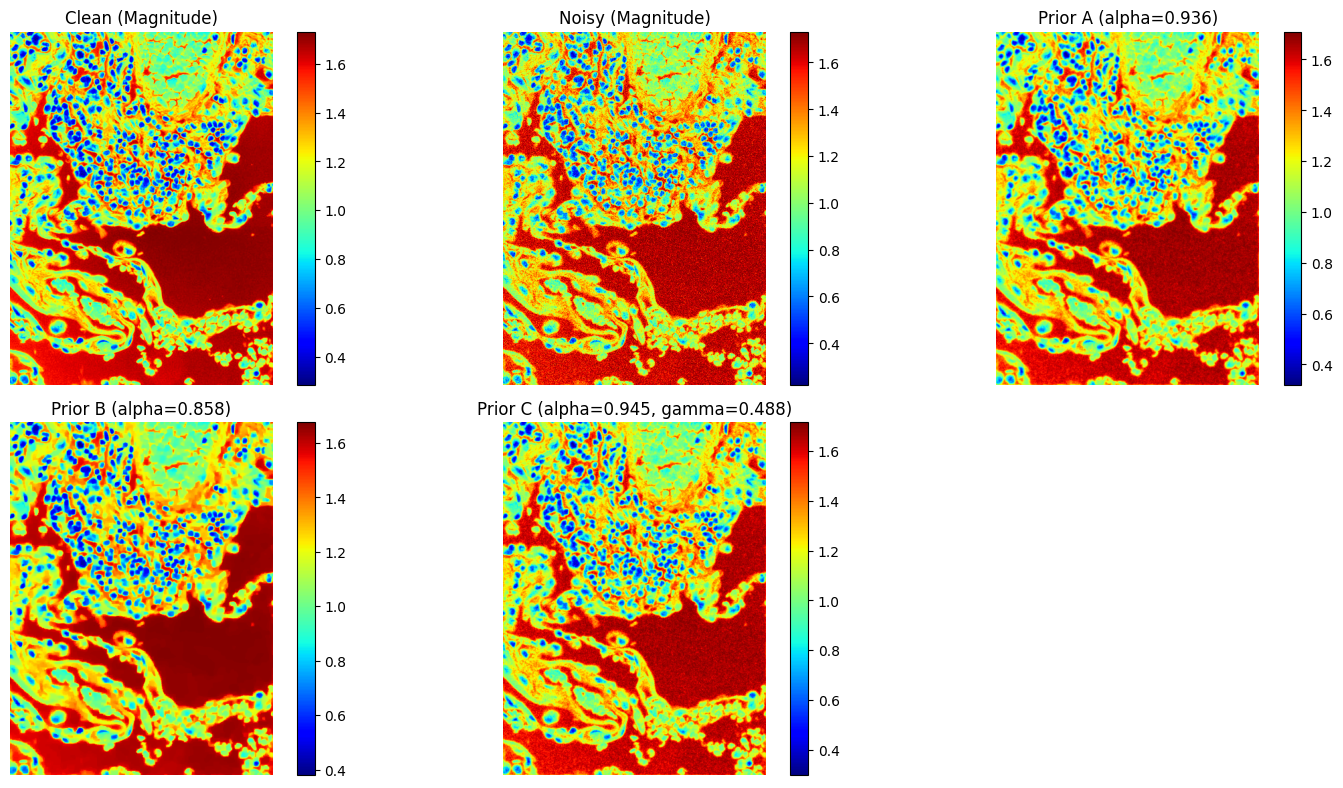

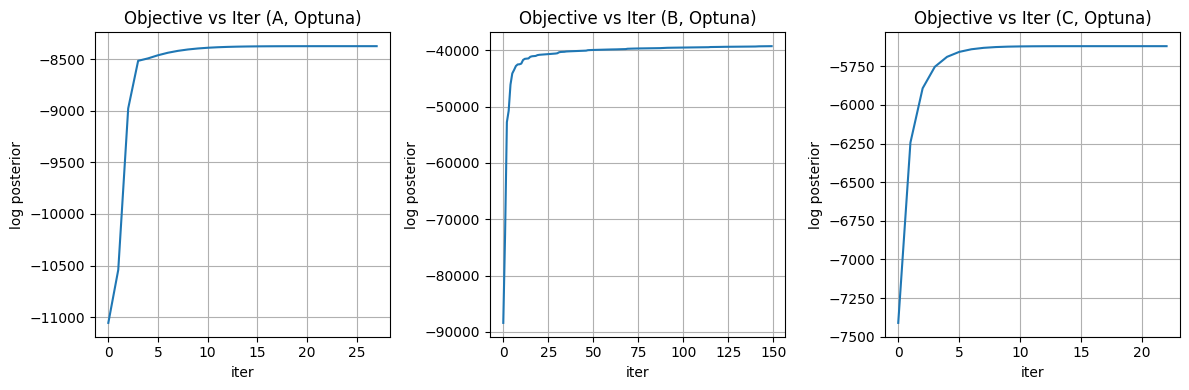

In [22]:
# Final denoising runs with Optuna best params and visualizations
den_A_opt, obj_A_opt = gradient_ascent_map(image_noisy, best_A_alpha_opt, 'A', sigma_est, max_iter=150)
den_B_opt, obj_B_opt = gradient_ascent_map(image_noisy, best_B_alpha_opt, 'B', sigma_est, max_iter=150)
den_C_opt, obj_C_opt = gradient_ascent_map(image_noisy, best_C_alpha_opt, 'C', sigma_est, gamma=best_C_gamma_opt, max_iter=150)

print('Final (Optuna) RRMSE A:', compute_rrmse(image_clean, den_A_opt))
print('Final (Optuna) RRMSE B:', compute_rrmse(image_clean, den_B_opt))
print('Final (Optuna) RRMSE C:', compute_rrmse(image_clean, den_C_opt))

plt.figure(figsize=(15,8))
plt.subplot(2,3,1); show_mag(image_clean, 'Clean (Magnitude)')
plt.subplot(2,3,2); show_mag(image_noisy, 'Noisy (Magnitude)')
plt.subplot(2,3,3); show_mag(den_A_opt, f'Prior A (alpha={best_A_alpha_opt:.3f})')
plt.subplot(2,3,4); show_mag(den_B_opt, f'Prior B (alpha={best_B_alpha_opt:.3f})')
plt.subplot(2,3,5); show_mag(den_C_opt, f'Prior C (alpha={best_C_alpha_opt:.3f}, gamma={best_C_gamma_opt:.3f})')
plt.tight_layout(); plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.plot(obj_A_opt); plt.title('Objective vs Iter (A, Optuna)'); plt.xlabel('iter'); plt.ylabel('log posterior'); plt.grid(True)
plt.subplot(1,3,2); plt.plot(obj_B_opt); plt.title('Objective vs Iter (B, Optuna)'); plt.xlabel('iter'); plt.ylabel('log posterior'); plt.grid(True)
plt.subplot(1,3,3); plt.plot(obj_C_opt); plt.title('Objective vs Iter (C, Optuna)'); plt.xlabel('iter'); plt.ylabel('log posterior'); plt.grid(True)
plt.tight_layout(); plt.show()